In [1]:
import tensorflow as tf 
import pandas as pd 
import en_core_web_md
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import os
import io

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('src/spam.csv', encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 5572

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [4]:
# dropping useless columns with too many missing values, rename columns and 
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
df = df.rename(columns={"v1":"target", "v2":"content"})
df['target'] = df['target'].apply(lambda x : 0 if x == "ham" else 1)
df.head()

,target,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# check the target
df['target'].value_counts()

0    4825
1     747
Name: target, dtype: int64

Text(0.5, 1.0, 'Distribution of the target')

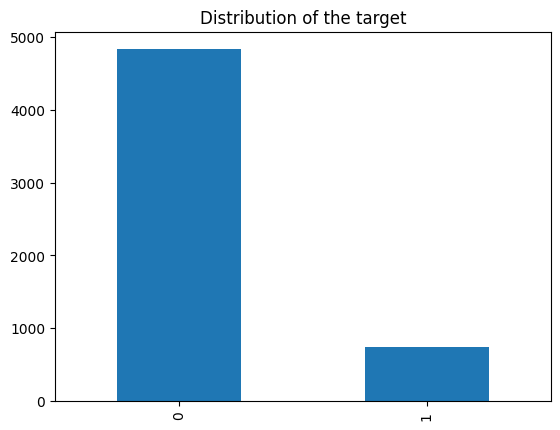

In [6]:
#plot the target
df['target'].value_counts().plot(kind='bar')
plt.title("Distribution of the target")

In [7]:
# explonary the dataset
df["characters_count"] = df["content"].apply(lambda x: len(x))
df['words_count'] = df['content'].apply (lambda x : len(x.split(' ')))

In [8]:
df.head(5)

,target,content,characters_count,words_count
0,0,"Go until jurong point, crazy.. Available only ...",111,20
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,0,U dun say so early hor... U c already then say...,49,11
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13


<AxesSubplot: title={'center': 'Words count mean and mediane by target'}, xlabel='target'>

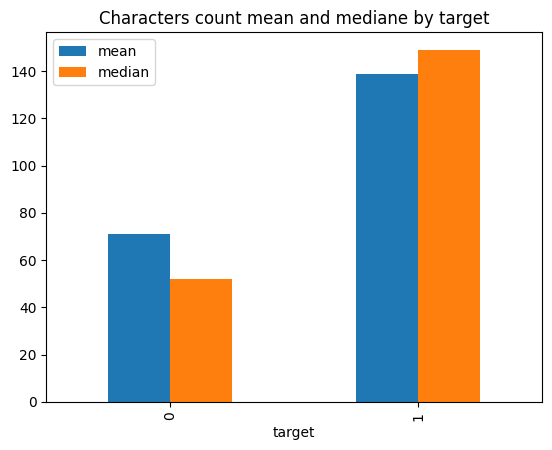

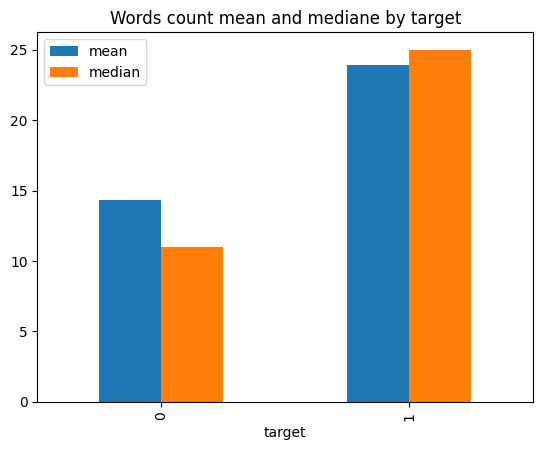

In [9]:
#plot first observation
df.groupby('target')['characters_count'].agg(['mean', 'median']).plot(kind='bar', title='Characters count mean and mediane by target')
df.groupby('target')['words_count'].agg(['mean', 'median']).plot(kind='bar', title='Words count mean and mediane by target')

In [10]:
# load english natural language processing (medium pack)
nlp = en_core_web_md.load()

In [11]:
#import stop words english
from spacy.lang.en.stop_words import STOP_WORDS

In [12]:
# cleaning text and lemma
df['text_clean'] = df["content"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==' ' or ch=="'"))
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
df.head()

,target,content,characters_count,words_count,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,20,jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,29,6,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,11,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,nah think usf live


In [13]:
#check mean of character count and words count by target
df.groupby(['target']).describe()

characters_count                                                    \
                  count        mean        std   min    25%    50%    75%   
target                                                                      
0                4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0   
1                 747.0  138.866131  29.183082  13.0  132.5  149.0  157.0   

              words_count                                                      
          max       count       mean        std  min   25%   50%   75%    max  
target                                                                         
0       910.0      4825.0  14.323938  11.538966  1.0   7.0  11.0  19.0  171.0  
1       224.0       747.0  23.892905   5.826977  2.0  22.0  25.0  28.0   35.0

In [14]:
# before training the model, we balance the dataset
df_ham = df[df['target'] == 0]
df_spam = df[df['target'] == 1]
df_ham2 = df_ham.sample(n=len(df_spam))
df2 = df_ham2.append(df_spam).reset_index(drop=True)
df2.head(20)

,target,content,characters_count,words_count,text_clean
0,0,MAKE SURE ALEX KNOWS HIS BIRTHDAY IS OVER IN F...,87,16,sure alex know birthday minute far concern
1,0,S but mostly not like that.,27,6,s like
2,0,Now thats going to ruin your thesis!,36,7,s ruin thesis
3,0,Am going to take bath ill place the key in win...,52,11,bath ill place key window
4,0,Lol now I'm after that hot air balloon!,39,8,lol hot air balloon
5,0,Hmmm...k...but i want to change the field quic...,114,16,hmmmkbut want change field quickly dai wanna s...
6,0,Yes:)here tv is always available in work place..,48,8,yeshere tv available work place
7,0,Go fool dont cheat others ok,28,6,fool cheat ok
8,0,\Hi darlin i cantdo anythingtomorrow as mypare...,105,17,hi darlin cantdo anythingtomorrow myparent are...
9,0,Alex knows a guy who sells mids but he's down ...,110,25,alex know guy sell mid south tampa think set l...


In [15]:
# features and target
X = df2['text_clean']
y = df2['target']

In [16]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(X, y, test_size=0.2)

In [17]:
#tokenizer and padding train and val

max_len = max([len(token) for token in df['text_clean'].to_list()])

tokenizer = Tokenizer(num_words=5000, oov_token="out_of_vocab")
tokenizer.fit_on_texts(xtrain)
tokenizer.fit_on_texts(xval)
text_encoded_train = tokenizer.texts_to_sequences(xtrain)
text_encoded_val = tokenizer.texts_to_sequences(xval)
padded_text_encoded_train = tf.keras.preprocessing.sequence.pad_sequences(text_encoded_train, maxlen=max_len)
padded_text_encoded_val = tf.keras.preprocessing.sequence.pad_sequences(text_encoded_val, maxlen=max_len)

In [18]:
#create model with 1 layer of embedding, 2 layers of lstm, 1 dense(relu) and 1 dense (sigmoid) on output
vocab_size = tokenizer.num_words
embedding_dim=64 # the dimensionality of the representation space

model = tf.keras.Sequential([
                              
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_shape=[max_len],name="embedding"),
    # the input dim needs to be equal to the size of the vocabulary + 1 (because of
    # the zero padding)
    LSTM(units=64, return_sequences=True), # maintains the sequential nature
    LSTM(units=32, return_sequences=False), # returns the last output
    Dense(16, activation='relu'), # a dense layer
    Dense(1, activation='sigmoid') # the prediction layer

])

# print the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 458, 64)           320064    
                                                                 
 lstm (LSTM)                 (None, 458, 64)           33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 366,049
Trainable params: 366,049
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# compile the model
optimizer= tf.keras.optimizers.Adam()

model.compile(  optimizer=optimizer, 
                loss=tf.keras.losses.BinaryCrossentropy(), 
                metrics=['accuracy']
            )

In [20]:
# fit the model
history = model.fit(padded_text_encoded_train,
                    ytrain,
                    batch_size=64,
                    validation_data=(padded_text_encoded_val, yval),
                    epochs=20)

Epoch 1/20
19/19 [==============================] - 13s 507ms/step - loss: 0.6387 - accuracy: 0.7356 - val_loss: 0.4911 - val_accuracy: 0.8763
Epoch 2/20
19/19 [==============================] - 8s 440ms/step - loss: 0.4014 - accuracy: 0.8636 - val_loss: 0.2835 - val_accuracy: 0.8896
Epoch 3/20
19/19 [==============================] - 8s 439ms/step - loss: 0.2061 - accuracy: 0.9297 - val_loss: 0.1909 - val_accuracy: 0.9331
Epoch 4/20
19/19 [==============================] - 8s 447ms/step - loss: 0.0745 - accuracy: 0.9782 - val_loss: 0.1395 - val_accuracy: 0.9532
Epoch 5/20
19/19 [==============================] - 8s 438ms/step - loss: 0.0277 - accuracy: 0.9925 - val_loss: 0.3477 - val_accuracy: 0.8763
Epoch 6/20
19/19 [==============================] - 8s 442ms/step - loss: 0.0145 - accuracy: 0.9975 - val_loss: 0.1862 - val_accuracy: 0.9365
Epoch 7/20
19/19 [==============================] - 9s 473ms/step - loss: 0.0092 - accuracy: 0.9983 - val_loss: 0.1651 - val_accuracy: 0.9465
Epoch

In [21]:
# return after sigmoid layer and tranform as int to have binary pred 0 or 1
ypred_train = (model.predict(padded_text_encoded_train) >0.5).astype("int32")
ypred_val = (model.predict(padded_text_encoded_val) >0.5).astype("int32")

10/10 [==============================] - 1s 86ms/step


In [22]:
#print accuracy on train and validation set
print(f"accuracy score on train set : {accuracy_score(ytrain, ypred_train)}")
print(f"accuracy score on validation set : {accuracy_score(yval, ypred_val)}")

accuracy score on train set : 1.0
accuracy score on validation set : 0.9464882943143813


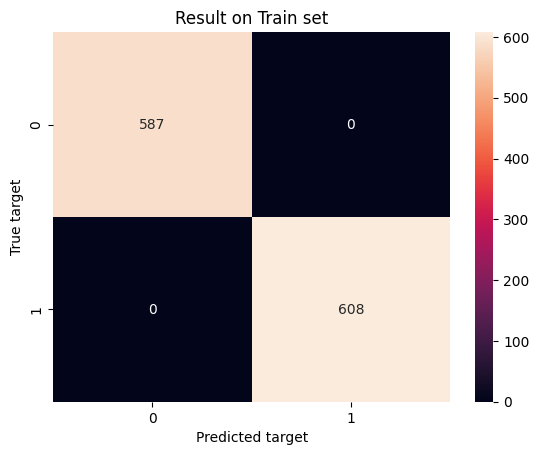

In [23]:
#plot confusion matrix for test
conf = confusion_matrix(ytrain, ypred_train)
sns.heatmap(conf, annot=True, fmt='d')
plt.ylabel('True target')
plt.xlabel('Predicted target')
plt.title('Result on Train set')
plt.show()

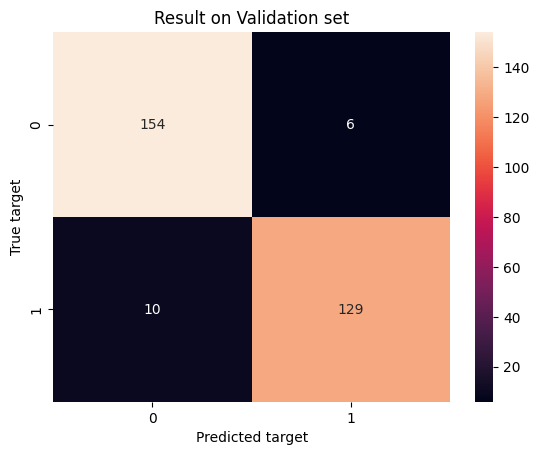

In [24]:
#plot confusion matrix for val
conf = confusion_matrix(yval, ypred_val)
sns.heatmap(conf, annot=True, fmt='d')
plt.ylabel('True target')
plt.xlabel('Predicted target')
plt.title('Result on Validation set')
plt.show()

On a une precison  avec 6 faux positif (vrai message considéré en spam) et un recall avec 10 faux négatif (spam considéré en vrai message)

In [36]:
#plot history of the loss and accuracy (training and val)
color_chart = ["red", "blue", "#FF6692", "#19D3F3"]

history_lstm = history.history
fig = go.Figure(data=[
                      go.Scatter(
                          y=history_lstm["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_lstm["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          )),
                      go.Scatter(
                          y=history_lstm["accuracy"],
                          name= "Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[2]
                          )),
                     go.Scatter(
                          y=history_lstm["val_accuracy"],
                          name= "Val accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[3]
                          ))
])
fig.update_layout(
    title='Training and val (loss and accuracy) across epochs',
    xaxis_title='epochs',
    yaxis_title='accuracy and loss'    
)
fig.show()

Le modéle s'entraine parfaitement sur le train, accuracy à 1, un peu moins sur le test.
Prochaine étape trouver un modèle pré-entrainer et essayer de faire mieux!